In [2]:
from Supplements import *
from NeuralNetsLoanEligibility import *
from matplotlib.offsetbox import AnchoredText

/Users/kshitijgoyal/opt/anaconda3/envs/LearningWithConstraints_IJCAI/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
start = time.time()
dataset = 'loan_data_set.csv'
data = pd.read_csv(dataset, header=0)
processed_output = data_processing(data)
data = processed_output[0]
X = data.iloc[:, 0:data.shape[1] - 1]
y_original = list(data.iloc[:, -1])
scaled_income = processed_output[1].scale_[0] * (5000 - processed_output[1].data_min_[0])
X, y = data_manipulation(X, y_original)
X.head(5)

['Education', 'Married', 'Dependents', 'Gender', 'Loan_Status', 'Property_Area', 'Self_Employed']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,0.054830,0.044567,0.201354,0.72973,1.0,1,1,1,0,0,0,0,0,0
1,0.035250,0.000000,0.096447,0.72973,1.0,1,1,0,0,0,0,1,0,1
2,0.030093,0.069687,0.187817,0.72973,1.0,1,1,0,0,0,1,0,0,1
3,0.072356,0.000000,0.223350,0.72973,1.0,1,0,0,0,0,0,0,0,1
4,0.065145,0.124006,0.436548,0.72973,1.0,1,1,0,1,0,0,1,0,1


In [211]:
def relu(element):
    return If(element > 0, element, 0)

relu_vectorized = np.vectorize(relu)

def sigmoid(element):
    return 1/(1 + pow(2.71, element))

sigmoid_vectorized = np.vectorize(sigmoid)


class LinearLayer:
    # only relu and sigmoid  activation is supported right now
    def __init__(self, layer_name=None, in_size=10, out_size=1, activation='None'):
        assert (layer_name is not None)
    
        self.layer_name = layer_name
        self.in_size = in_size
        self.out_size = out_size
        self.W = np.array([np.array(RealVector(layer_name + '__{}'.format(i), in_size + 1))
                               for i in range(out_size)])
        self.output = None
        self.activation = activation
        print('Layer: {}; size: [{} {}]; Activation: {}'.format(self.layer_name, self.in_size,
                                                                    self.out_size, self.activation))

    def compute(self, X):
        print(self.W)
        if self.activation == 'Relu':
            self.output = relu_vectorized(np.matmul(np.insert(X, 0, 1, axis=1), np.transpose(self.W)))
        elif self.activation == 'Sigmoid':
            self.output = sigmoid_vectorized(np.matmul(np.insert(X, 0, 1, axis=1), np.transpose(self.W)))
        else:
            self.output = np.matmul(np.insert(X, 0, 1, axis=1), np.transpose(self.W))
            
        
class NeuralNet(Optimizer):
    def __init__(self, sizes=None):
        assert (len(sizes) >= 2)
        super().__init__()
        
        self.sizes = sizes
        self.Layers = []

        for i in range(len(sizes) - 1):
            if i != len(sizes) - 2:
                self.Layers.append(LinearLayer('l{}'.format(i + 1), sizes[i], sizes[i + 1],
                                                   activation='Relu'))
            else:
                self.Layers.append(LinearLayer('l{}'.format(i + 1), sizes[i], sizes[i + 1],
                                                   activation='None'))
        self.W = []
        self.training_accuracies = []
        self.training_losses = []

    def forward(self, X):
        output_data = X
        for i in range(len(self.Layers)):
            self.Layers[i].compute(output_data)
            output_data = self.Layers[i].output
            print(len(output_data), len(output_data[0]))
        return output_data

    def add_knowledge_constraints(self, X, y, K=None):
        pass

    def add_decision_constraints(self, X, y):
        Fs = []
        Fh = []
        Predictions = self.forward(X)
        
        for i in range(X.shape[0]):
            if y[i] == 1:
                Fh.append(self.T[i] == (Predictions[i][0] > 0))
            else:
                Fh.append(self.T[i] == (Predictions[i][0] < 0))
            
            Fs.append(self.T[i])

        self.Soft_Constraints.extend(Fs)
        self.Hard_Constraints.extend(Fh)

    def add_weight_constraints(self, low=-100, high=100):
        print('adding weight constraints')
        self.Hard_Constraints.append(And([And([And([And(self.Layers[i].W[j][k] >= low, self.Layers[i].W[j][k] <= high)
                                                    for k in range(self.Layers[i].in_size + 1)])
                                               for j in range(self.Layers[i].out_size)])
                                          for i in range(len(self.Layers))]))

    
    def add_gradient_constraints(self, learning_rate=0.1, gradients=None):
        assert (gradients is not None)
        self.Hard_Constraints.append(And([And([And([And(self.Layers[i].W[j][k] <= self.W[i][j][k],
                                                                    self.Layers[i].W[j][k] >= self.W[i][j][k] -
                                                                    learning_rate)
                                                                if gradients[i][j][k] > 0 else
                                                                And(self.Layers[i].W[j][k] <= self.W[i][j][k] +
                                                                    learning_rate,
                                                                    self.Layers[i].W[j][k] >= self.W[i][j][k])
                                                                for k in range(self.Layers[i].in_size + 1)])
                                                           for j in range(self.Layers[i].out_size)])
                                                      for i in range(len(self.Layers))]))
    
    def learn(self, X, y, K=None, batch_size=5, epochs=5, learning_rate=0.1):
        self.relaxation = 1

        all_indices = list(range(X.shape[0]))
        random.shuffle(all_indices)
        all_batches = [all_indices[i * batch_size: (i + 1) * batch_size]
                       for i in range(int(len(all_indices) / batch_size))]

        gradients = []
        for e in range(epochs):
            for b in range(len(all_batches)):
                active_indices = all_batches[b]
                print('number of instances being considered:', len(active_indices))
                X_sub = X[active_indices]
                y_sub = [y[i] for i in active_indices]

                if K is not None:
                    self.add_knowledge_constraints(X, y, K)
                    print('knowledge constraints added')

                if len(self.W) > 0:
                    self.add_gradient_constraints(learning_rate, gradients)

                self.T = BoolVector('t', len(active_indices))
                self.add_weight_constraints(low=-100, high=100)
                self.add_decision_constraints(X_sub, y_sub)
                self.OptimizationFuMalik(length=1)

                if self.out == sat:
                    self.get_weights()
                    print(self.W)
                    predictions, gradients, loss, accuracy = self.predict(X, y)
                    print('training accuracy:', accuracy)
                    self.training_accuracies.append(accuracy)
                    self.training_losses.append(loss)
                else:
                    print('found unknown. reversing gradients')
                    gradients = [[[gradients[i][j][k] * -1 for k in range(self.Layers[i].in_size + 1)]
                                  for j in range(self.Layers[i].out_size)]
                                 for i in range(len(self.Layers))]
                self.Soft_Constraints = []
                self.Hard_Constraints = []
                self.T = None
                self.solver.reset()
                self.out = None

    def get_weights(self):
        self.W = [[[self.solver.model()[L.W[i][j]].numerator_as_long() /
                    self.solver.model()[L.W[i][j]].denominator_as_long() if self.solver.model()[L.W[i][j]] is not None
                    else 0 for j in range(L.in_size + 1)] for i in range(L.out_size)]
                  for L in self.Layers]

    def predict(self, X, y):
        mirror_model = NeuralNetTorch(self.sizes)
        for i in range(len(mirror_model.Layers)):
            mirror_model.Layers[i].weight = nn.Parameter(torch.Tensor([w[1:] for w in self.W[i]]))
            mirror_model.Layers[i].bias = nn.Parameter(torch.Tensor([w[0] for w in self.W[i]]))
        out = mirror_model(torch.Tensor(X))
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(out, torch.Tensor([[v] for v in y]).type(torch.FloatTensor))
        loss.backward()
        gradients_bias = [mirror_model.Layers[i].bias.grad.tolist() for i in range(len(mirror_model.Layers))]
        gradients_weights = [mirror_model.Layers[i].weight.grad.tolist() for i in range(len(mirror_model.Layers))]
        gradients = [[[gradients_bias[i][j]] + gradients_weights[i][j]
                      for j in range(len(gradients_weights[i]))]
                     for i in range(len(mirror_model.Layers))]
        y_pred = [1 if o[0] > 0 else 0 for o in out.tolist()]
        accuracy = accuracy_score(y, y_pred)
        return out, gradients, loss.detach().cpu().numpy().item(), accuracy


In [473]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
y = list(data['target'])
X = pd.DataFrame(data['data'])
X = data_processing(X)[0]
data = X.copy()
data['y'] = y
data = data.sample(frac=1)
data.reset_index(inplace=True, drop=True)
X = data.iloc[:, :-1]
y = data.iloc[:, -1].tolist()
X, y

[]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


(           0         1         2         3         4         5         6   \
 0    0.215770  0.034156  0.206897  0.112662  0.300984  0.123643  0.032029   
 1    0.638885  0.397362  0.613019  0.493107  0.279137  0.196614  0.211856   
 2    0.202045  0.171458  0.190657  0.104560  0.274713  0.077296  0.002281   
 3    0.197785  0.395671  0.187686  0.100445  0.443893  0.123919  0.020982   
 4    0.218609  0.499831  0.210352  0.116098  0.199603  0.115024  0.046251   
 ..        ...       ...       ...       ...       ...       ...       ...   
 564  0.782290  0.492391  0.769194  0.680170  0.489934  0.334090  0.540769   
 565  0.320365  0.475482  0.309239  0.189396  0.250970  0.149347  0.110052   
 566  0.397037  0.441326  0.389814  0.248017  0.355421  0.258328  0.262887   
 567  0.150930  0.174839  0.143459  0.071432  0.548614  0.187811  0.025398   
 568  0.225709  0.354075  0.223274  0.117200  0.507990  0.290534  0.160333   
 
            7         8         9   ...        20        21   

In [214]:
K = [scaled_income, 0]
K = None
sizes = [X.shape[1], 4, 1]
batch_size = 10
epochs = 5
learning_rate = 0.1
model = NeuralNet(sizes=sizes)
model.learn(np.array(X), y, K=K, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
print(model.training_accuracies)
print(model.training_losses)

Layer: l1; size: [30 4]; Activation: Relu
Layer: l2; size: [4 1]; Activation: None
number of instances being considered: 10
adding weight constraints
[[l1__0__0 l1__0__1 l1__0__2 l1__0__3 l1__0__4 l1__0__5 l1__0__6 l1__0__7
  l1__0__8 l1__0__9 l1__0__10 l1__0__11 l1__0__12 l1__0__13 l1__0__14
  l1__0__15 l1__0__16 l1__0__17 l1__0__18 l1__0__19 l1__0__20 l1__0__21
  l1__0__22 l1__0__23 l1__0__24 l1__0__25 l1__0__26 l1__0__27 l1__0__28
  l1__0__29 l1__0__30]
 [l1__1__0 l1__1__1 l1__1__2 l1__1__3 l1__1__4 l1__1__5 l1__1__6 l1__1__7
  l1__1__8 l1__1__9 l1__1__10 l1__1__11 l1__1__12 l1__1__13 l1__1__14
  l1__1__15 l1__1__16 l1__1__17 l1__1__18 l1__1__19 l1__1__20 l1__1__21
  l1__1__22 l1__1__23 l1__1__24 l1__1__25 l1__1__26 l1__1__27 l1__1__28
  l1__1__29 l1__1__30]
 [l1__2__0 l1__2__1 l1__2__2 l1__2__3 l1__2__4 l1__2__5 l1__2__6 l1__2__7
  l1__2__8 l1__2__9 l1__2__10 l1__2__11 l1__2__12 l1__2__13 l1__2__14
  l1__2__15 l1__2__16 l1__2__17 l1__2__18 l1__2__19 l1__2__20 l1__2__21
  l1__2__22 

IndexError: list index out of range

In [32]:
X.shape

(480, 14)

In [143]:
# plt.figure()
# plt.subplot(211)
# plt.plot(model.training_accuracies)
# plt.annotate('layers: {}'.format(sizes), xy=(0.05, 1.05), xycoords='axes fraction')
# plt.ylim(top=1)
# plt.ylim(bottom=0)
# plt.xlabel('batches')
# plt.ylabel('training accuracy')
# plt.subplot(212)
# plt.plot(model.training_losses)
# plt.xlabel('batches')
# plt.ylabel('training entropy loss')

# filename = 'training_set_weight_constraint.png'
# plt.savefig(filename)
# plt.close()

In [10]:
def relu(element):
    return If(element > 0, element, 0)

relu_vectorized = np.vectorize(relu)

def sigmoid(element):
    return 1/(1 + pow(2.71, element))

sigmoid_vectorized = np.vectorize(sigmoid)


class LinearLayer:
    # only relu and sigmoid  activation is supported right now
    def __init__(self, layer_name=None, in_size=10, out_size=1, activation='None'):
        assert (layer_name is not None)
    
        self.layer_name = layer_name
        self.in_size = in_size
        self.out_size = out_size
        self.W = np.array([np.array([1.0*Int(layer_name + '__{}__{}'.format(i, j)) for j in range(in_size + 1)])
                               for i in range(out_size)])
        self.output = None
        self.activation = activation
        print('Layer: {}; size: [{} {}]; Activation: {}'.format(self.layer_name, self.in_size,
                                                                    self.out_size, self.activation))

    def compute(self, X):
        if self.activation == 'Relu':
            self.output = relu_vectorized(np.matmul(np.insert(X, 0, 1.0, axis=1), np.transpose(self.W)))
        elif self.activation == 'Sigmoid':
            self.output = sigmoid_vectorized(np.matmul(np.insert(X, 0, 1.0, axis=1), np.transpose(self.W)))
        else:
            self.output = np.matmul(np.insert(X, 0, 1, axis=1), np.transpose(self.W))
            
        
class BinarizedNeuralNet(Optimizer):
    def __init__(self, sizes=None):
        assert (len(sizes) >= 2)
        super().__init__()
        
        self.sizes = sizes
        self.Layers = []

        for i in range(len(sizes) - 1):
            if i != len(sizes) - 2:
                self.Layers.append(LinearLayer('l{}'.format(i + 1), sizes[i], sizes[i + 1],
                                                   activation='Relu'))
            else:
                self.Layers.append(LinearLayer('l{}'.format(i + 1), sizes[i], sizes[i + 1],
                                                   activation='None'))
        self.W = []
        self.training_accuracies = []
        self.training_losses = []

    def forward(self, X):
        output_data = X
        for i in range(len(self.Layers)):
            self.Layers[i].compute(output_data)
            output_data = self.Layers[i].output
            print(len(output_data), len(output_data[0]))
        return output_data

    def add_knowledge_constraints(self, X, y, K=None):
        pass

    def add_decision_constraints(self, X, y):
        Fs = []
        Fh = []
        Predictions = self.forward(X)
        
        for i in range(X.shape[0]):
            if y[i] == 1:
                print((Predictions[i][0] > 0))
                Fh.append(self.T[i] == (Predictions[i][0] > 0))
            else:
                print((Predictions[i][0] < 0))
                Fh.append(self.T[i] == (Predictions[i][0] < 0))
            
            Fs.append(self.T[i])

        self.Soft_Constraints.extend(Fs)
        self.Hard_Constraints.extend(Fh)

    def add_weight_constraints(self):
        print('adding weight constraints')
        self.Hard_Constraints.append(And([And([And([Or(self.Layers[i].W[j][k] <= 1000, 
                                                       self.Layers[i].W[j][k] >= -1000)
                                                    for k in range(self.Layers[i].in_size + 1)])
                                               for j in range(self.Layers[i].out_size)])
                                          for i in range(len(self.Layers))]))

    
        
    def add_gradient_constraints(self, learning_rate=1, gradients=None):
        assert (gradients is not None)
        for i in range(len(self.Layers)):
            for j in range(self.Layers[i].out_size):
                for k in range(self.Layers[i].in_size + 1):
                    if gradients[i][j][k] > 0:
                        self.Hard_Constraints.append(And(self.Layers[i].W[j][k] < self.W[i][j][k],
                                                                    self.Layers[i].W[j][k] >= self.W[i][j][k] -
                                                                    learning_rate))
                    elif gradients[i][j][k] < 0:
                        self.Hard_Constraints.append(And(self.Layers[i].W[j][k] > self.W[i][j][k],
                                                                    self.Layers[i].W[j][k] <= self.W[i][j][k] +
                                                                    learning_rate))
    
    def learn(self, X, y, K=None, batch_size=5, epochs=5, learning_rate=0.1):
        self.relaxation = 1

        all_indices = list(range(X.shape[0]))
        random.shuffle(all_indices)
        all_batches = [all_indices[i * batch_size: (i + 1) * batch_size]
                       for i in range(int(len(all_indices) / batch_size))]

        gradients = []
        for e in range(epochs):
            for b in range(len(all_batches)):
                active_indices = all_batches[b]
                print('number of instances being considered:', len(active_indices))
                X_sub = X[active_indices]
                y_sub = [y[i] for i in active_indices]
                print(y_sub)
                
                if K is not None:
                    self.add_knowledge_constraints(X, y, K)
                    print('knowledge constraints added')

                if len(gradients) > 0:
                    self.add_gradient_constraints(learning_rate, gradients)

                self.T = BoolVector('t', len(active_indices))
                self.add_weight_constraints()
                self.add_decision_constraints(X_sub, y_sub)
                self.OptimizationFuMalik(length=1)

                if self.out == sat:
                    self.get_weights()
                    print(self.W)
                    predictions, gradients, loss, accuracy = self.predict(X, y)
                    print('training accuracy:', accuracy)
                    print('gradients:', gradients)
                    print('loss:', loss)
                    self.training_accuracies.append(accuracy)
                    self.training_losses.append(loss)
                else:
                    print('found unknown. reversing gradients')
                    gradients = [[[gradients[i][j][k] * -1 for k in range(self.Layers[i].in_size + 1)]
                                  for j in range(self.Layers[i].out_size)]
                                 for i in range(len(self.Layers))]
                self.Soft_Constraints = []
                self.Hard_Constraints = []
                self.T = None
                self.solver.reset()
                self.out = None
#                 sys.exit(0)

    def get_weights(self):
        self.W = [[[self.solver.model().evaluate(L.W[i][j]).as_long() for j in range(L.in_size + 1)] for i in range(L.out_size)]
                  for L in self.Layers]
#         self.W = [[[self.solver.model()[L.W[i][j]].numerator_as_long() /
#                     self.solver.model()[L.W[i][j]].denominator_as_long() if self.solver.model()[L.W[i][j]] is not None
#                     else 0 for j in range(L.in_size + 1)] for i in range(L.out_size)]
#                   for L in self.Layers]

    def predict(self, X, y):
        mirror_model = NeuralNetTorch(self.sizes)
        for i in range(len(mirror_model.Layers)):
            mirror_model.Layers[i].weight = nn.Parameter(torch.Tensor([w[1:] for w in self.W[i]]))
            mirror_model.Layers[i].bias = nn.Parameter(torch.Tensor([w[0] for w in self.W[i]]))
        out = mirror_model(torch.Tensor(X))
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(out, torch.Tensor([[v] for v in y]).type(torch.FloatTensor))
        loss.backward()
        gradients_bias = [mirror_model.Layers[i].bias.grad.tolist() for i in range(len(mirror_model.Layers))]
        gradients_weights = [mirror_model.Layers[i].weight.grad.tolist() for i in range(len(mirror_model.Layers))]
        gradients = [[[gradients_bias[i][j]] + gradients_weights[i][j]
                      for j in range(len(gradients_weights[i]))]
                     for i in range(len(mirror_model.Layers))]
        y_pred = [1 if o[0] > 0 else 0 for o in out.tolist()]
        accuracy = accuracy_score(y, y_pred)
        return out, gradients, loss.detach().cpu().numpy().item(), accuracy


In [11]:
K = [scaled_income, 0]
K = None
sizes = [X.iloc[:, :4].shape[1], 1]
batch_size = 5
epochs = 10
learning_rate = 1
model = BinarizedNeuralNet(sizes=sizes)
model.learn(np.array(X.iloc[:, :4]), y, K=K, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
print(model.training_accuracies)
print(model.training_losses)

Layer: l1; size: [4 1]; Activation: None
number of instances being considered: 5
[1, 1, 0, 0, 1]
adding weight constraints
5 1
1*1*l1__0__0 +
0*1*l1__0__1 +
0*1*l1__0__2 +
0*1*l1__0__3 +
0*1*l1__0__4 >
0
1*1*l1__0__0 +
0*1*l1__0__1 +
0*1*l1__0__2 +
0*1*l1__0__3 +
0*1*l1__0__4 >
0
1*1*l1__0__0 +
0*1*l1__0__1 +
0*1*l1__0__2 +
0*1*l1__0__3 +
0*1*l1__0__4 <
0
1*1*l1__0__0 +
0*1*l1__0__1 +
0*1*l1__0__2 +
0*1*l1__0__3 +
0*1*l1__0__4 <
0
1*1*l1__0__0 +
0*1*l1__0__1 +
0*1*l1__0__2 +
0*1*l1__0__3 +
0*1*l1__0__4 >
0
starting the check
found unsat
size of core: 2
found unsat
size of core: 2
found sat
[[[1, 0, 0, 0, 0]]]
training accuracy: 0.7520833333333333
gradients: [[[-0.02102475054562092, 0.0007745595648884773, 0.001205267384648323, -0.0007626187289133668, -0.014154322445392609]]]
loss: 0.5611783266067505
number of instances being considered: 5
[1, 1, 0, 1, 1]
adding weight constraints
5 1
1*1*l1__0__0 +
0*1*l1__0__1 +
0*1*l1__0__2 +
0*1*l1__0__3 +
0*1*l1__0__4 >
0
1*1*l1__0__0 +
0*1*l1__0__1

ArgumentError: argument 2: <class 'KeyboardInterrupt'>: 

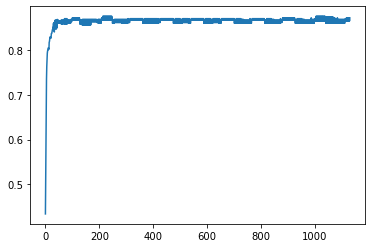

In [658]:
plt.plot(model.training_accuracies)

In [17]:
linear = LinearClassificationLearner()
linear.learn(X, y, M=[0], relaxation=1, K=None, weight_limit=100,
             learner='fumalik', batch_size=5, epochs=10, learning_rate=0.1)

number of instances being considered: 5
starting the check
found sat
learned parameters
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
gradient: [-0.2183872906164577, -0.012720058938464842, -0.007828615854930008, -0.048560991451080435, -0.14994027396243476, -0.2220804217488744, -0.1800902282214785, -0.16752697864156213, -0.06012448582418799, -0.04188776142466634, -0.01802402368949992, -0.03228383016210404, -0.032370589255708314, -0.14769557190866703, -0.012429471458936314]
runtime: 0.003983020782470703
training accuracy: 0.35
number of instances being considered: 5
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
starting the check
found sat
learned parameters
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, -0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 1.1]
gradient: [-0.08908710833133825, -0.0040458196554364325, -0.0015451265220441295, -0.017622771585405483, -0.06077992703251179, -0.1088774555820005, -0.06887479915026098, -0.07499115701769737, -0.03440143624849987,

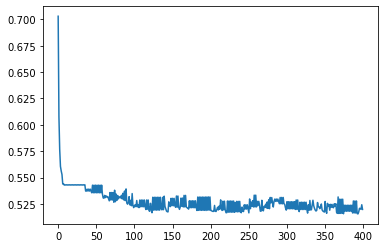

In [16]:
plt.plot(linear.training_losses)